# University of Michigan 
# Master of Applied Data Science
### SIAD 699: Capstone
Team: James Yoon (jamyoon), Mario Feliciano (felicma), and James Tuccori (jtuccori)

Date: April 2023
____
# Social Media Sentiment & Predicting Trading Signals 

##### In this notebook, we add financials indicatiors and basic binary increase or decreasing indicators as features. We then run all the 177 features with 25,503 data points through an LSTM model. For our assessment we use a GPU enabled computer to allow us to process the Kerelas model faster.

##### The output of the notebook is the prediction of the model for the 7,340 testing data points, which will be used in Step 5 back testing.  LSTMPrediction.csv

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree
from adspy_shared_utilities import plot_class_regions_for_classifier
from adspy_shared_utilities import plot_decision_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from adspy_shared_utilities import plot_decision_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from finta import TA
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
import glob
import os

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Add new features for the financial indifcators from finta library. Also importing the Traing Data below from Step 2. Creating an expotential smoothing to help reduce significant variance in the close data. Then creating binary indicators of the columns and financial features to use as new features. 

In [5]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']
Df_hourly_merge = pd.read_csv('assets/MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv')

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

Indicatordata = _exponential_smooth(Df_hourly_merge[['Close', 'Open','High','Low','Volume']], 0.65)
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

   
    return data

Indicatordatafinal = _get_indicator_data(Indicatordata)

Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
Df_hourly_merge2 = pd.merge(Df_hourly_merge, Indicatordatafinal, left_index=True, right_index=True)

Df_hourly_merge2 = Df_hourly_merge2.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)




def binary(value):
  if value > 0:
    return 1
  else:
    return 0

columns = ['favorites', 'retweets', 'number_of_followers', 'following',
           'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
           'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
           'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
           'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
           'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
           '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
           '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
           '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']


for column in columns: 
    Df_hourly_merge2['Binary{}'.format(column)]  = (Df_hourly_merge2[column]- Df_hourly_merge2[column].shift(1) ).apply(binary)
    

In [6]:
Df_hourly_merge2.columns.values

array(['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
       'JMJ_5HMoving_averages', 'Actual_Label',
       'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'Mkt Sentiment', 'Crypto Sentiment',
       'Historically Optimal SMA(s-t)', 'Historically Optimal SMA(l-t)',
       'Historically Optimal WMA(s-t)', 'Historically Optimal WMA(l-t)',
       'Historically Optimal EMA(s-t)', 'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',


#### Identifying what exactly are the features and the label

In [7]:
Df_hourly_merge2 = Df_hourly_merge2[['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
       'JMJ_5HMoving_averages', 
       'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'Mkt Sentiment', 'Crypto Sentiment',
       'Historically Optimal SMA(s-t)', 'Historically Optimal SMA(l-t)',
       'Historically Optimal WMA(s-t)', 'Historically Optimal WMA(l-t)',
       'Historically Optimal EMA(s-t)', 'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',
       'Twitter Hourly Favorites EMA(l-t)',
       'Twitter Hourly Retweets SMA(s-t)',
       'Twitter Hourly Retweets SMA(l-t)',
       'Twitter Hourly Retweets WMA(s-t)',
       'Twitter Hourly Retweets WMA(l-t)',
       'Twitter Hourly Retweets EMA(s-t)',
       'Twitter Hourly Retweets EMA(l-t)',
       'Twitter Hourly Follower Exposure SMA(s-t)',
       'Twitter Hourly Follower Exposure SMA(l-t)',
       'Twitter Hourly Follower Exposure WMA(s-t)',
       'Twitter Hourly Follower Exposure WMA(l-t)',
       'Twitter Hourly Follower Exposure EMA(s-t)',
       'Twitter Hourly Follower Exposure EMA(l-t)',
       'Twitter Hourly Following Exposure SMA(s-t)',
       'Twitter Hourly Following Exposure SMA(l-t)',
       'Twitter Hourly Following Exposure WMA(s-t)',
       'Twitter Hourly Following Exposure WMA(l-t)',
       'Twitter Hourly Following Exposure EMA(s-t)',
       'Twitter Hourly Following Exposure EMA(l-t)',
       'Twitter Hourly Follower to Following Ratio SMA(s-t)',
       'Twitter Hourly Follower to Following Ratio SMA(l-t)',
       'Twitter Hourly Follower to Following Ratio WMA(s-t)',
       'Twitter Hourly Follower to Following Ratio WMA(l-t)',
       'Twitter Hourly Follower to Following Ratio EMA(s-t)',
       'Twitter Hourly Follower to Following Ratio EMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(l-t)',
       'Twitter Hourly Polarity Score SMA(s-t)',
       'Twitter Hourly Polarity Score SMA(l-t)',
       'Twitter Hourly Polarity Score WMA(s-t)',
       'Twitter Hourly Polarity Score WMA(l-t)',
       'Twitter Hourly Polarity Score EMA(s-t)',
       'Twitter Hourly Polarity Score EMA(l-t)',
       'Twitter W1 Score SMA(s-t)', 'Twitter W1 Score SMA(l-t)',
       'Twitter W1 Score WMA(s-t)', 'Twitter W1 Score WMA(l-t)',
       'Twitter W1 Score EMA(s-t)', 'Twitter W1 Score EMA(l-t)',
       'Twitter Hourly Bull Ratio SMA(s-t)',
       'Twitter Hourly Bull Ratio SMA(l-t)',
       'Twitter Hourly Bull Ratio WMA(s-t)',
       'Twitter Hourly Bull Ratio WMA(l-t)',
       'Twitter Hourly Bull Ratio EMA(s-t)',
       'Twitter Hourly Bull Ratio EMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
       'Quote Asset Volume SMA(s-t)', 'Quote Asset Volume SMA(l-t)',
       'Quote Asset Volume WMA(s-t)', 'Quote Asset Volume WMA(l-t)',
       'Quote Asset Volume EMA(s-t)', 'Quote Asset Volume EMA(l-t)',
       '# of Hourly Trades SMA(s-t)', '# of Hourly Trades SMA(l-t)',
       '# of Hourly Trades WMA(s-t)', '# of Hourly Trades WMA(l-t)',
       '# of Hourly Trades EMA(s-t)', '# of Hourly Trades EMA(l-t)',
       'TB Base Volume SMA(s-t)', 'TB Base Volume SMA(l-t)',
       'TB Base Volume WMA(s-t)', 'TB Base Volume WMA(l-t)',
       'TB Base Volume EMA(s-t)', 'TB Base Volume EMA(l-t)',
       'TB Quote Volume SMA(s-t)', 'TB Quote Volume SMA(l-t)',
       'TB Quote Volume WMA(s-t)', 'TB Quote Volume WMA(l-t)',
       'TB Quote Volume EMA(s-t)', 'TB Quote Volume EMA(l-t)',
       '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV',
       '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21',
       'ema15', 'ema5', 'normVol', 'Binaryfavorites', 'Binaryretweets',
       'Binarynumber_of_followers', 'Binaryfollowing',
       'Binaryfollowers_following_ratio', 'Binary2x_retweets_+_favorites',
       'Binarypolarity', 'BinaryW1 Score', 'BinaryBull_ratio',
       'BinaryW Score With Bull Ratio', 'BinaryOpen', 'BinaryHigh',
       'BinaryLow', 'BinaryClose', 'BinaryVolume',
       'BinaryQuote Asset Volume', 'BinaryNumber of Trades',
       'BinaryTB Base Volume', 'BinaryTB Quote Volume',
       'Binary3MovingAverage', 'Binary5MovingAverage',
       'BinaryJMJ_3HMoving_averages', 'BinaryJMJ_5HMoving_averages',
       'Binary14 period RSI', 'BinaryMACD', 'BinarySIGNAL',
       'Binary14 period STOCH %K', 'BinaryMFV', 'Binary14 period ATR',
       'BinaryMOM', 'Binary14 period MFI', 'BinaryROC', 'BinaryOBV',
       'Binary20 period CCI', 'Binary14 period EMV', 'BinaryVIm',
       'BinaryVIp', 'Binaryema50', 'Binaryema21', 'Binaryema15',
       'Binaryema5','Actual_Label']]
Df_hourly_merge2

,favorites,retweets,number_of_followers,following,followers_following_ratio,2x_retweets_+_favorites,polarity,W1 Score,Bull_ratio,W Score With Bull Ratio,...,BinaryOBV,Binary20 period CCI,Binary14 period EMV,BinaryVIm,BinaryVIp,Binaryema50,Binaryema21,Binaryema15,Binaryema5,Actual_Label
0,6.517857,1.276786,10592.354167,1652.068452,45.605159,9.071429,0.124241,0.264455,3.275000,0.866089,...,0,0,0,0,0,0,0,0,0,1.0
1,2.685230,0.479419,14341.610169,1852.799031,74.444302,3.644068,0.067950,0.097316,3.342105,0.325240,...,0,0,0,0,0,1,1,1,1,0.0
2,2.138107,0.670077,21769.074169,2449.731458,68.571009,3.478261,0.120056,0.144203,6.120000,0.882520,...,0,0,0,0,0,0,0,0,0,0.0
3,1.916462,0.670762,36958.090909,2790.968059,100.500076,3.257985,0.143717,0.110483,5.964286,0.658951,...,0,0,0,0,0,0,0,0,0,0.0
4,4.339394,0.921212,13345.724242,3208.639394,66.105667,6.181818,0.136780,0.199699,4.607143,0.920041,...,0,1,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25498,5.783333,0.659524,12129.000000,1975.276190,108.150291,7.102381,0.077630,0.078660,3.022222,0.237728,...,0,1,1,0,1,0,0,0,0,0.0
25499,3.011905,0.392857,14180.595238,1765.121429,31.755382,3.797619,0.095683,0.135134,4.277778,0.578073,...,0,0,1,0,1,0,0,0,0,0.0
25500,14.400000,2.407143,16161.992857,2084.061905,182.260151,19.214286,0.082271,0.107210,3.648649,0.391172,...,0,0,0,1,0,0,0,0,0,1.0
25501,21.570806,3.270153,11254.296296,1814.954248,428.484448,28.111111,0.070485,0.165014,1.887324,0.311435,...,1,0,0,1,0,1,1,1,1,0.0


In [8]:
Df_hourly_merge2.shape

(25503, 178)

In [9]:
Df_hourly_merge2

,favorites,retweets,number_of_followers,following,followers_following_ratio,2x_retweets_+_favorites,polarity,W1 Score,Bull_ratio,W Score With Bull Ratio,...,BinaryOBV,Binary20 period CCI,Binary14 period EMV,BinaryVIm,BinaryVIp,Binaryema50,Binaryema21,Binaryema15,Binaryema5,Actual_Label
0,6.517857,1.276786,10592.354167,1652.068452,45.605159,9.071429,0.124241,0.264455,3.275000,0.866089,...,0,0,0,0,0,0,0,0,0,1.0
1,2.685230,0.479419,14341.610169,1852.799031,74.444302,3.644068,0.067950,0.097316,3.342105,0.325240,...,0,0,0,0,0,1,1,1,1,0.0
2,2.138107,0.670077,21769.074169,2449.731458,68.571009,3.478261,0.120056,0.144203,6.120000,0.882520,...,0,0,0,0,0,0,0,0,0,0.0
3,1.916462,0.670762,36958.090909,2790.968059,100.500076,3.257985,0.143717,0.110483,5.964286,0.658951,...,0,0,0,0,0,0,0,0,0,0.0
4,4.339394,0.921212,13345.724242,3208.639394,66.105667,6.181818,0.136780,0.199699,4.607143,0.920041,...,0,1,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25498,5.783333,0.659524,12129.000000,1975.276190,108.150291,7.102381,0.077630,0.078660,3.022222,0.237728,...,0,1,1,0,1,0,0,0,0,0.0
25499,3.011905,0.392857,14180.595238,1765.121429,31.755382,3.797619,0.095683,0.135134,4.277778,0.578073,...,0,0,1,0,1,0,0,0,0,0.0
25500,14.400000,2.407143,16161.992857,2084.061905,182.260151,19.214286,0.082271,0.107210,3.648649,0.391172,...,0,0,0,1,0,0,0,0,0,1.0
25501,21.570806,3.270153,11254.296296,1814.954248,428.484448,28.111111,0.070485,0.165014,1.887324,0.311435,...,1,0,0,1,0,1,1,1,1,0.0


In [10]:
Df_hourly_merge2 =Df_hourly_merge2.dropna()

In [11]:
Df_hourly_merge2

,favorites,retweets,number_of_followers,following,followers_following_ratio,2x_retweets_+_favorites,polarity,W1 Score,Bull_ratio,W Score With Bull Ratio,...,BinaryOBV,Binary20 period CCI,Binary14 period EMV,BinaryVIm,BinaryVIp,Binaryema50,Binaryema21,Binaryema15,Binaryema5,Actual_Label
14,2.192488,0.607981,12657.115023,2370.725352,94.001469,3.408451,0.127865,0.140353,4.289474,0.602043,...,0,0,0,0,0,0,0,0,0,1.0
15,3.116915,0.711443,19247.771144,3072.072139,38.739274,4.539801,0.157796,0.326886,5.620690,1.837327,...,0,0,0,1,0,0,0,0,1,1.0
16,2.392857,0.774554,32692.765625,2729.649554,76.403309,3.941964,0.110599,0.235383,3.714286,0.874281,...,1,1,0,1,1,1,1,1,1,0.0
17,19.276688,3.483660,26051.699346,2012.346405,119.262203,26.244009,0.139567,0.455197,5.540541,2.522036,...,0,1,1,0,1,1,1,1,1,1.0
18,3.627451,0.740196,21007.830882,2123.634804,48.496435,5.107843,0.160742,0.182470,5.843750,1.066306,...,1,1,1,0,1,1,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25498,5.783333,0.659524,12129.000000,1975.276190,108.150291,7.102381,0.077630,0.078660,3.022222,0.237728,...,0,1,1,0,1,0,0,0,0,0.0
25499,3.011905,0.392857,14180.595238,1765.121429,31.755382,3.797619,0.095683,0.135134,4.277778,0.578073,...,0,0,1,0,1,0,0,0,0,0.0
25500,14.400000,2.407143,16161.992857,2084.061905,182.260151,19.214286,0.082271,0.107210,3.648649,0.391172,...,0,0,0,1,0,0,0,0,0,1.0
25501,21.570806,3.270153,11254.296296,1814.954248,428.484448,28.111111,0.070485,0.165014,1.887324,0.311435,...,1,0,0,1,0,1,1,1,1,0.0


#  LSTM  Model

In [12]:
Df_hourly_merge3= Df_hourly_merge2.copy()

In [13]:
Df_hourly_merge3

,favorites,retweets,number_of_followers,following,followers_following_ratio,2x_retweets_+_favorites,polarity,W1 Score,Bull_ratio,W Score With Bull Ratio,...,BinaryOBV,Binary20 period CCI,Binary14 period EMV,BinaryVIm,BinaryVIp,Binaryema50,Binaryema21,Binaryema15,Binaryema5,Actual_Label
14,2.192488,0.607981,12657.115023,2370.725352,94.001469,3.408451,0.127865,0.140353,4.289474,0.602043,...,0,0,0,0,0,0,0,0,0,1.0
15,3.116915,0.711443,19247.771144,3072.072139,38.739274,4.539801,0.157796,0.326886,5.620690,1.837327,...,0,0,0,1,0,0,0,0,1,1.0
16,2.392857,0.774554,32692.765625,2729.649554,76.403309,3.941964,0.110599,0.235383,3.714286,0.874281,...,1,1,0,1,1,1,1,1,1,0.0
17,19.276688,3.483660,26051.699346,2012.346405,119.262203,26.244009,0.139567,0.455197,5.540541,2.522036,...,0,1,1,0,1,1,1,1,1,1.0
18,3.627451,0.740196,21007.830882,2123.634804,48.496435,5.107843,0.160742,0.182470,5.843750,1.066306,...,1,1,1,0,1,1,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25498,5.783333,0.659524,12129.000000,1975.276190,108.150291,7.102381,0.077630,0.078660,3.022222,0.237728,...,0,1,1,0,1,0,0,0,0,0.0
25499,3.011905,0.392857,14180.595238,1765.121429,31.755382,3.797619,0.095683,0.135134,4.277778,0.578073,...,0,0,1,0,1,0,0,0,0,0.0
25500,14.400000,2.407143,16161.992857,2084.061905,182.260151,19.214286,0.082271,0.107210,3.648649,0.391172,...,0,0,0,1,0,0,0,0,0,1.0
25501,21.570806,3.270153,11254.296296,1814.954248,428.484448,28.111111,0.070485,0.165014,1.887324,0.311435,...,1,0,0,1,0,1,1,1,1,0.0


In [14]:
Df_hourly_merge3.columns.values

array(['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
       'JMJ_5HMoving_averages', 'Bitcoin_Google_Trend_Score',
       'BTC_Google_Trend_Score', 'Mkt Sentiment', 'Crypto Sentiment',
       'Historically Optimal SMA(s-t)', 'Historically Optimal SMA(l-t)',
       'Historically Optimal WMA(s-t)', 'Historically Optimal WMA(l-t)',
       'Historically Optimal EMA(s-t)', 'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',
       'Twitter Hourly 

In [15]:
Df_hourly_merge3.shape

(25489, 178)

####  This code performs a timeseriessplit cross validation of 25,503 training data points taking the past 12 timesteps (last 12 hours of data) when training. We selected 12 times steps, at 128 neurons, with a 0.1 dropout, and 0.001 learning rate, after spending over 70 hours doing an extensive analysis of all the different features paramters. We then selected the paramters with the highest validation accuracy overall. 


In [16]:
%%time

Df_hourly_merge3= Df_hourly_merge2.copy()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
Df_hourly_merge3_without_label = Df_hourly_merge3.iloc[:, :-1] # Exclude the label column
scaler.fit(Df_hourly_merge3_without_label)

# Define the number of timesteps and features
timesteps = 12
features =  177

# Create the input and output sequences
X = []
y = []

for i in range(timesteps, Df_hourly_merge3.shape[0]): 
    X.append(scaler.transform(Df_hourly_merge3.iloc[i-timesteps:i, :-1])) #All features except last column
    y.append(Df_hourly_merge3.iloc[i, -1]) #Label column
X, y = np.array(X), np.array(y)

# Reshape the data to match the input shape of the LSTM model
X = np.reshape(X, (X.shape[0], X.shape[1], features))


# Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

LTSM_RESULTS = []

for train_index, test_index in tscv.split(X):
    print(train_index, test_index)
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], features)))
    model.add(LSTM(128, return_sequences=True)
    model.add(LSTM(128,dropout = 0.1))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#     #Early stop
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)

    # Fit the model to the training data
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stop])

    # Make predictions
    y_pred = model.predict(X_test)
    testy_pred = (y_pred >= 0.5).astype(int)
    
    LTSMaccuracy = accuracy_score(y_test, testy_pred)
    LTSM_RESULTS.append(LTSMaccuracy)

    # Print classification report
    print(classification_report(y_test, testy_pred))
    print(confusion_matrix(y_test, testy_pred))

        
print('LTSM Accuracy = ' + str( sum(LTSM_RESULTS) / len(LTSM_RESULTS)))



[   0    1    2 ... 2314 2315 2316] [2317 2318 2319 ... 4630 4631 4632]
73/73 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

         0.0       0.50      0.42      0.46      1083
         1.0       0.56      0.64      0.59      1233

    accuracy                           0.53      2316
   macro avg       0.53      0.53      0.53      2316
weighted avg       0.53      0.53      0.53      2316

[[456 627]
 [450 783]]
[   0    1    2 ... 4630 4631 4632] [4633 4634 4635 ... 6946 6947 6948]
73/73 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

         0.0       0.57      0.03      0.05      1177
         1.0       0.49      0.98      0.66      1139

    accuracy                           0.50      2316
   macro avg       0.53      0.50      0.35      2316
weighted avg       0.53      0.50      0.35      2316

[[  31 1146]
 [  23 1116]]
[   0    1    2 ... 6946 6947 6948] [6949 6950

In [17]:
model

#### SAVE MODEL

In [18]:
#Save model
model.save('model/100EPOCHSNews_Google_API_GPUTimeSeriesTweekThreshold_JT_OptimizedLSTMone.h5')

#### LOAD MODEL

In [19]:
#Load Model
from tensorflow.keras.models import load_model

loaded_model = load_model('model/100EPOCHSNews_Google_API_GPUTimeSeriesTweekThreshold_JT_OptimizedLSTMone.h5')

# TESTING RESULTS

#### Importing the 7,340 testing dat apoints, adding the same financial indicators, binary feautres, then testing the performance of our model on the unseen data

227/227 [==============================] - 2s 5ms/step
[[1468 2186]
 [1356 2247]]


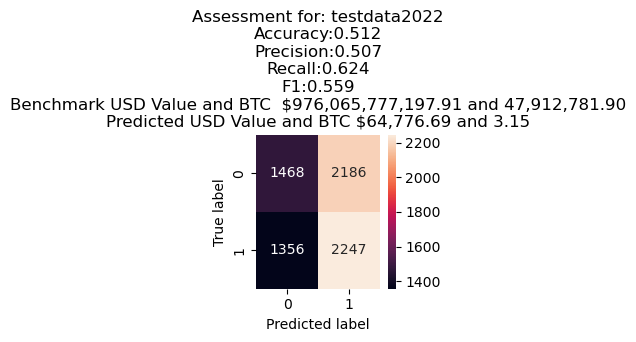

In [21]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']


testdata2022 ='assets/TEST_MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv'


files= [testdata2022]

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    return data

UpperThreshold = 0.5
LowerThresshold = 0.5

for file,x in zip(files, ['testdata2022']):
    PredictDF= pd.read_csv(file)

    Indicatordata = _exponential_smooth(PredictDF[['Close', 'Open','High','Low','Volume']], 0.65)

    Indicatordatafinal = _get_indicator_data(Indicatordata)

    Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
    PredictDF = pd.merge(PredictDF, Indicatordatafinal, left_index=True, right_index=True)
    PredictDF = PredictDF.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)

    
    
    
    
    columns = ['favorites', 'retweets', 'number_of_followers', 'following',
           'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
           'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
           'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
           'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
           'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
           '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
           '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
           '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']

    
    def binary(value):
        if value > 0:
            return 1
        else:
            return 0

    for column in columns: 
        PredictDF['Binary{}'.format(column)]  = (PredictDF[column] - PredictDF[column].shift(1)).apply(binary)
    

    PredictDF = PredictDF.dropna()

    PredictDF = PredictDF[['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
       'JMJ_5HMoving_averages', 
       'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'Mkt Sentiment', 'Crypto Sentiment',
       'Historically Optimal SMA(s-t)', 'Historically Optimal SMA(l-t)',
       'Historically Optimal WMA(s-t)', 'Historically Optimal WMA(l-t)',
       'Historically Optimal EMA(s-t)', 'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',
       'Twitter Hourly Favorites EMA(l-t)',
       'Twitter Hourly Retweets SMA(s-t)',
       'Twitter Hourly Retweets SMA(l-t)',
       'Twitter Hourly Retweets WMA(s-t)',
       'Twitter Hourly Retweets WMA(l-t)',
       'Twitter Hourly Retweets EMA(s-t)',
       'Twitter Hourly Retweets EMA(l-t)',
       'Twitter Hourly Follower Exposure SMA(s-t)',
       'Twitter Hourly Follower Exposure SMA(l-t)',
       'Twitter Hourly Follower Exposure WMA(s-t)',
       'Twitter Hourly Follower Exposure WMA(l-t)',
       'Twitter Hourly Follower Exposure EMA(s-t)',
       'Twitter Hourly Follower Exposure EMA(l-t)',
       'Twitter Hourly Following Exposure SMA(s-t)',
       'Twitter Hourly Following Exposure SMA(l-t)',
       'Twitter Hourly Following Exposure WMA(s-t)',
       'Twitter Hourly Following Exposure WMA(l-t)',
       'Twitter Hourly Following Exposure EMA(s-t)',
       'Twitter Hourly Following Exposure EMA(l-t)',
       'Twitter Hourly Follower to Following Ratio SMA(s-t)',
       'Twitter Hourly Follower to Following Ratio SMA(l-t)',
       'Twitter Hourly Follower to Following Ratio WMA(s-t)',
       'Twitter Hourly Follower to Following Ratio WMA(l-t)',
       'Twitter Hourly Follower to Following Ratio EMA(s-t)',
       'Twitter Hourly Follower to Following Ratio EMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(l-t)',
       'Twitter Hourly Polarity Score SMA(s-t)',
       'Twitter Hourly Polarity Score SMA(l-t)',
       'Twitter Hourly Polarity Score WMA(s-t)',
       'Twitter Hourly Polarity Score WMA(l-t)',
       'Twitter Hourly Polarity Score EMA(s-t)',
       'Twitter Hourly Polarity Score EMA(l-t)',
       'Twitter W1 Score SMA(s-t)', 'Twitter W1 Score SMA(l-t)',
       'Twitter W1 Score WMA(s-t)', 'Twitter W1 Score WMA(l-t)',
       'Twitter W1 Score EMA(s-t)', 'Twitter W1 Score EMA(l-t)',
       'Twitter Hourly Bull Ratio SMA(s-t)',
       'Twitter Hourly Bull Ratio SMA(l-t)',
       'Twitter Hourly Bull Ratio WMA(s-t)',
       'Twitter Hourly Bull Ratio WMA(l-t)',
       'Twitter Hourly Bull Ratio EMA(s-t)',
       'Twitter Hourly Bull Ratio EMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
       'Quote Asset Volume SMA(s-t)', 'Quote Asset Volume SMA(l-t)',
       'Quote Asset Volume WMA(s-t)', 'Quote Asset Volume WMA(l-t)',
       'Quote Asset Volume EMA(s-t)', 'Quote Asset Volume EMA(l-t)',
       '# of Hourly Trades SMA(s-t)', '# of Hourly Trades SMA(l-t)',
       '# of Hourly Trades WMA(s-t)', '# of Hourly Trades WMA(l-t)',
       '# of Hourly Trades EMA(s-t)', '# of Hourly Trades EMA(l-t)',
       'TB Base Volume SMA(s-t)', 'TB Base Volume SMA(l-t)',
       'TB Base Volume WMA(s-t)', 'TB Base Volume WMA(l-t)',
       'TB Base Volume EMA(s-t)', 'TB Base Volume EMA(l-t)',
       'TB Quote Volume SMA(s-t)', 'TB Quote Volume SMA(l-t)',
       'TB Quote Volume WMA(s-t)', 'TB Quote Volume WMA(l-t)',
       'TB Quote Volume EMA(s-t)', 'TB Quote Volume EMA(l-t)',
       '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV',
       '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21',
       'ema15', 'ema5', 'normVol', 'Binaryfavorites', 'Binaryretweets',
       'Binarynumber_of_followers', 'Binaryfollowing',
       'Binaryfollowers_following_ratio', 'Binary2x_retweets_+_favorites',
       'Binarypolarity', 'BinaryW1 Score', 'BinaryBull_ratio',
       'BinaryW Score With Bull Ratio', 'BinaryOpen', 'BinaryHigh',
       'BinaryLow', 'BinaryClose', 'BinaryVolume',
       'BinaryQuote Asset Volume', 'BinaryNumber of Trades',
       'BinaryTB Base Volume', 'BinaryTB Quote Volume',
       'Binary3MovingAverage', 'Binary5MovingAverage',
       'BinaryJMJ_3HMoving_averages', 'BinaryJMJ_5HMoving_averages',
       'Binary14 period RSI', 'BinaryMACD', 'BinarySIGNAL',
       'Binary14 period STOCH %K', 'BinaryMFV', 'Binary14 period ATR',
       'BinaryMOM', 'Binary14 period MFI', 'BinaryROC', 'BinaryOBV',
       'Binary20 period CCI', 'Binary14 period EMV', 'BinaryVIm',
       'BinaryVIp', 'Binaryema50', 'Binaryema21', 'Binaryema15',
       'Binaryema5','Actual_Label']]
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    PredictDF_without_label = PredictDF.iloc[:, :-1] # Exclude the label column
    scaler.fit(PredictDF_without_label)
    
    # Define the number of timesteps and features
    timesteps = 12
    features = 177

    # Create the input and output sequences
    X = []
    y = []

    for i in range(timesteps, PredictDF.shape[0]): 
        X.append(scaler.transform(PredictDF.iloc[i-timesteps:i, :-1])) #All features except last column
        y.append(PredictDF.iloc[i, -1]) #Label column
    X, y = np.array(X), np.array(y)

    # Reshape the data to match the input shape of the LSTM model
    X = np.reshape(X, (X.shape[0], X.shape[1], features))
    
    
    # Make predictions
    y_pred = loaded_model.predict(X)

    PredictDF = PredictDF[-y_pred.shape[0]:]
    predict_y = (y_pred >= 0.5).astype(int)
    PredictDF['Predicted_Label']= predict_y

    confusion_mc = confusion_matrix(PredictDF['Actual_Label'], PredictDF['Predicted_Label'])
    print(confusion_mc)
    df_cm = pd.DataFrame(confusion_mc, 
                         index = [i for i in range(0,2)], columns = [i for i in range(0,2)])


    PredictDF['ValueActual'] =0
    PredictDF['BTCValueActual'] =0
    if PredictDF.loc[PredictDF.index[0],'Actual_Label']==0.0:
        PredictDF.loc[PredictDF.index[0],'ValueActual']=100000
    else:
        PredictDF.loc[PredictDF.index[0],'BTCValueActual']=round((100000/PredictDF.loc[PredictDF.index[0],'Close']),5)


    for current in range(1, len(PredictDF.index)):
        previous = current - 1

        if PredictDF.loc[PredictDF.index[current],'Actual_Label']==0 and PredictDF.loc[PredictDF.index[previous],'BTCValueActual']==0:
            PredictDF.loc[PredictDF.index[current],'ValueActual']=PredictDF.loc[PredictDF.index[previous],'ValueActual']
        elif PredictDF.loc[PredictDF.index[current],'Actual_Label']==1 and PredictDF.loc[PredictDF.index[previous],'ValueActual'] ==0 :
            PredictDF.loc[PredictDF.index[current],'ValueActual']= 0
            PredictDF.loc[PredictDF.index[current],'BTCValueActual']=round(PredictDF.loc[PredictDF.index[previous],'BTCValueActual'],3)
        elif PredictDF.loc[PredictDF.index[current],'Actual_Label']==1:
            PredictDF.loc[PredictDF.index[current],'BTCValueActual'] = round((PredictDF.loc[PredictDF.index[previous],'ValueActual']/PredictDF.loc[PredictDF.index[current],'Close']),5)
        else:
            PredictDF.loc[PredictDF.index[current],'ValueActual'] = round((PredictDF.loc[PredictDF.index[previous],'BTCValueActual'] *PredictDF.loc[PredictDF.index[current],'Close']),3)


    PredictDF['ValuePredicted'] =0
    PredictDF['BTCValuePredicted'] =0
    if PredictDF.loc[PredictDF.index[0],'Predicted_Label']==0.0:
        PredictDF.loc[PredictDF.index[0],'ValuePredicted']=100000
    else:
        PredictDF.loc[PredictDF.index[0],'BTCValuePredicted']=round((100000/PredictDF.loc[PredictDF.index[0],'Close']),5)


    for current in range(1, len(PredictDF.index)):
        previous = current - 1

        if PredictDF.loc[PredictDF.index[current],'Predicted_Label']==0 and PredictDF.loc[PredictDF.index[previous],'BTCValuePredicted']==0:
            PredictDF.loc[PredictDF.index[current],'ValuePredicted']=PredictDF.loc[PredictDF.index[previous],'ValuePredicted']
        elif PredictDF.loc[PredictDF.index[current],'Predicted_Label']==1 and PredictDF.loc[PredictDF.index[previous],'ValuePredicted'] ==0 :
            PredictDF.loc[PredictDF.index[current],'ValuePredicted']= 0
            PredictDF.loc[PredictDF.index[current],'BTCValuePredicted']=round(PredictDF.loc[PredictDF.index[previous],'BTCValuePredicted'],3)
        elif PredictDF.loc[PredictDF.index[current],'Predicted_Label']==1:
            PredictDF.loc[PredictDF.index[current],'BTCValuePredicted'] = round((PredictDF.loc[PredictDF.index[previous],'ValuePredicted']/PredictDF.loc[PredictDF.index[current],'Close']),5)
        else:
            PredictDF.loc[PredictDF.index[current],'ValuePredicted'] = round((PredictDF.loc[PredictDF.index[previous],'BTCValuePredicted'] *PredictDF.loc[PredictDF.index[current],'Close']),3)
    df = PredictDF.mask(PredictDF==0).ffill().iloc[[-1]]
    LastPredictvalue = df['ValuePredicted'].values[0]
    LastPredictBTC = df['BTCValuePredicted'].values[0]


    plt.figure(figsize=(2,2))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Assessment for: {}\nAccuracy:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\nF1:{:.3f}\nBenchmark USD Value and BTC  ${:,.2f} and {:,.2f}\nPredicted USD Value and BTC ${:,.2f} and {:,.2f}'.format(x, accuracy_score(PredictDF['Actual_Label'],PredictDF['Predicted_Label']),
                                                                        precision_score(PredictDF['Actual_Label'],PredictDF['Predicted_Label']),
                                                                                    recall_score(PredictDF['Actual_Label'], PredictDF['Predicted_Label']),
                                                                                    f1_score(PredictDF['Actual_Label'], PredictDF['Predicted_Label']),
                                                                                     max(PredictDF['ValueActual']),max(PredictDF['BTCValueActual']),
                                                                                     LastPredictvalue,LastPredictBTC
                                                                                    ))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Exporting Predictions

In [22]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

testdata2022 ='assets/TEST_MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv'


files= [testdata2022]

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    return data

UpperThreshold = 0.5
LowerThresshold = 0.5

for file,x in zip(files, ['testdata2022']):
    PredictDF= pd.read_csv(file)

    
    Indicatordata = _exponential_smooth(PredictDF[['Close', 'Open','High','Low','Volume']], 0.65)

    Indicatordatafinal = _get_indicator_data(Indicatordata)

    Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
    PredictDF = pd.merge(PredictDF, Indicatordatafinal, left_index=True, right_index=True)
    PredictDF = PredictDF.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)
    
    
    
    
    
    columns = ['favorites', 'retweets', 'number_of_followers', 'following',
           'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
           'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
           'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
           'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
           'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
           '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
           '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
           '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']

    
    def binary(value):
        if value > 0:
            return 1
        else:
            return 0

    for column in columns: 
        PredictDF['Binary{}'.format(column)]  = (PredictDF[column] - PredictDF[column].shift(1)).apply(binary)
    

    PredictDF = PredictDF.dropna()

    PredictDF = PredictDF[['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
       'JMJ_5HMoving_averages', 
       'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'Mkt Sentiment', 'Crypto Sentiment',
       'Historically Optimal SMA(s-t)', 'Historically Optimal SMA(l-t)',
       'Historically Optimal WMA(s-t)', 'Historically Optimal WMA(l-t)',
       'Historically Optimal EMA(s-t)', 'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',
       'Twitter Hourly Favorites EMA(l-t)',
       'Twitter Hourly Retweets SMA(s-t)',
       'Twitter Hourly Retweets SMA(l-t)',
       'Twitter Hourly Retweets WMA(s-t)',
       'Twitter Hourly Retweets WMA(l-t)',
       'Twitter Hourly Retweets EMA(s-t)',
       'Twitter Hourly Retweets EMA(l-t)',
       'Twitter Hourly Follower Exposure SMA(s-t)',
       'Twitter Hourly Follower Exposure SMA(l-t)',
       'Twitter Hourly Follower Exposure WMA(s-t)',
       'Twitter Hourly Follower Exposure WMA(l-t)',
       'Twitter Hourly Follower Exposure EMA(s-t)',
       'Twitter Hourly Follower Exposure EMA(l-t)',
       'Twitter Hourly Following Exposure SMA(s-t)',
       'Twitter Hourly Following Exposure SMA(l-t)',
       'Twitter Hourly Following Exposure WMA(s-t)',
       'Twitter Hourly Following Exposure WMA(l-t)',
       'Twitter Hourly Following Exposure EMA(s-t)',
       'Twitter Hourly Following Exposure EMA(l-t)',
       'Twitter Hourly Follower to Following Ratio SMA(s-t)',
       'Twitter Hourly Follower to Following Ratio SMA(l-t)',
       'Twitter Hourly Follower to Following Ratio WMA(s-t)',
       'Twitter Hourly Follower to Following Ratio WMA(l-t)',
       'Twitter Hourly Follower to Following Ratio EMA(s-t)',
       'Twitter Hourly Follower to Following Ratio EMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(l-t)',
       'Twitter Hourly Polarity Score SMA(s-t)',
       'Twitter Hourly Polarity Score SMA(l-t)',
       'Twitter Hourly Polarity Score WMA(s-t)',
       'Twitter Hourly Polarity Score WMA(l-t)',
       'Twitter Hourly Polarity Score EMA(s-t)',
       'Twitter Hourly Polarity Score EMA(l-t)',
       'Twitter W1 Score SMA(s-t)', 'Twitter W1 Score SMA(l-t)',
       'Twitter W1 Score WMA(s-t)', 'Twitter W1 Score WMA(l-t)',
       'Twitter W1 Score EMA(s-t)', 'Twitter W1 Score EMA(l-t)',
       'Twitter Hourly Bull Ratio SMA(s-t)',
       'Twitter Hourly Bull Ratio SMA(l-t)',
       'Twitter Hourly Bull Ratio WMA(s-t)',
       'Twitter Hourly Bull Ratio WMA(l-t)',
       'Twitter Hourly Bull Ratio EMA(s-t)',
       'Twitter Hourly Bull Ratio EMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
       'Quote Asset Volume SMA(s-t)', 'Quote Asset Volume SMA(l-t)',
       'Quote Asset Volume WMA(s-t)', 'Quote Asset Volume WMA(l-t)',
       'Quote Asset Volume EMA(s-t)', 'Quote Asset Volume EMA(l-t)',
       '# of Hourly Trades SMA(s-t)', '# of Hourly Trades SMA(l-t)',
       '# of Hourly Trades WMA(s-t)', '# of Hourly Trades WMA(l-t)',
       '# of Hourly Trades EMA(s-t)', '# of Hourly Trades EMA(l-t)',
       'TB Base Volume SMA(s-t)', 'TB Base Volume SMA(l-t)',
       'TB Base Volume WMA(s-t)', 'TB Base Volume WMA(l-t)',
       'TB Base Volume EMA(s-t)', 'TB Base Volume EMA(l-t)',
       'TB Quote Volume SMA(s-t)', 'TB Quote Volume SMA(l-t)',
       'TB Quote Volume WMA(s-t)', 'TB Quote Volume WMA(l-t)',
       'TB Quote Volume EMA(s-t)', 'TB Quote Volume EMA(l-t)',
       '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV',
       '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21',
       'ema15', 'ema5', 'normVol', 'Binaryfavorites', 'Binaryretweets',
       'Binarynumber_of_followers', 'Binaryfollowing',
       'Binaryfollowers_following_ratio', 'Binary2x_retweets_+_favorites',
       'Binarypolarity', 'BinaryW1 Score', 'BinaryBull_ratio',
       'BinaryW Score With Bull Ratio', 'BinaryOpen', 'BinaryHigh',
       'BinaryLow', 'BinaryClose', 'BinaryVolume',
       'BinaryQuote Asset Volume', 'BinaryNumber of Trades',
       'BinaryTB Base Volume', 'BinaryTB Quote Volume',
       'Binary3MovingAverage', 'Binary5MovingAverage',
       'BinaryJMJ_3HMoving_averages', 'BinaryJMJ_5HMoving_averages',
       'Binary14 period RSI', 'BinaryMACD', 'BinarySIGNAL',
       'Binary14 period STOCH %K', 'BinaryMFV', 'Binary14 period ATR',
       'BinaryMOM', 'Binary14 period MFI', 'BinaryROC', 'BinaryOBV',
       'Binary20 period CCI', 'Binary14 period EMV', 'BinaryVIm',
       'BinaryVIp', 'Binaryema50', 'Binaryema21', 'Binaryema15',
       'Binaryema5','Actual_Label']]
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    PredictDF_without_label = PredictDF.iloc[:, :-1] # Exclude the label column
    scaler.fit(PredictDF_without_label)
    
    # Define the number of timesteps and features
    timesteps = 12
    features = 177

    # Create the input and output sequences
    X = []
    y = []

    for i in range(timesteps, PredictDF.shape[0]): 
        X.append(scaler.transform(PredictDF.iloc[i-timesteps:i, :-1])) #All features except last column
        y.append(PredictDF.iloc[i, -1]) #Label column
    X, y = np.array(X), np.array(y)

    # Reshape the data to match the input shape of the LSTM model
    X = np.reshape(X, (X.shape[0], X.shape[1], features))
    

    
    # Make predictions
    y_pred = loaded_model.predict(X)
    PredictDF = PredictDF[-y_pred.shape[0]:]
    PredictDF['Predictions']= y_pred



    

227/227 [==============================] - 1s 5ms/step


In [23]:
PredictDF

,favorites,retweets,number_of_followers,following,followers_following_ratio,2x_retweets_+_favorites,polarity,W1 Score,Bull_ratio,W Score With Bull Ratio,...,Binary20 period CCI,Binary14 period EMV,BinaryVIm,BinaryVIp,Binaryema50,Binaryema21,Binaryema15,Binaryema5,Actual_Label,Predictions
26,5.136364,0.531100,11300.291866,2380.129187,314.471806,6.198565,0.095330,0.296519,3.634146,1.077592,...,1,1,0,1,1,1,1,1,1.0,0.620424
27,8.050633,0.550633,10326.626582,1993.319620,250.413552,9.151899,0.090893,0.170252,3.176471,0.540800,...,1,1,0,1,1,1,1,1,0.0,0.481985
28,6.173246,0.521930,11648.758772,1679.736842,204.060989,7.217105,0.073569,0.103882,2.614035,0.271552,...,1,1,0,1,1,1,1,0,0.0,0.547518
29,8.146341,2.226829,27957.317073,1619.921951,199.531274,12.600000,0.062009,0.052451,2.290909,0.120161,...,1,1,0,1,0,0,0,0,1.0,0.567902
30,14.968912,2.681347,17172.707254,1825.471503,280.722305,20.331606,0.078020,0.098758,4.214286,0.416195,...,1,1,0,1,1,1,1,1,1.0,0.495936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7278,9.507143,3.530952,10695.850000,805.514286,264.229345,16.569048,0.075146,0.250643,2.518519,0.631248,...,1,1,0,1,0,0,0,1,1.0,0.744259
7279,17.957143,4.402381,22596.990476,846.535714,217.348828,26.761905,0.104180,0.403896,2.941176,1.187930,...,0,0,1,1,0,1,1,1,1.0,0.801605
7280,4.788095,1.021429,21378.707143,730.971429,172.471290,6.830952,0.097456,0.310215,4.176471,1.295602,...,1,0,1,0,1,1,1,1,0.0,0.559878
7281,10.600000,1.764286,15495.466667,663.738095,170.085989,14.128571,0.078864,0.206627,3.250000,0.671536,...,1,0,1,0,0,0,0,0,1.0,0.547587


In [24]:
PredictDF.to_csv('predictions/LSTMPrediction.csv')